# Extração de Entidades Nomeadas em Prontuários Médicos

Este notebook tem como objetivo realizar a extração de entidades nomeadas (NER - Named Entity Recognition) de arquivos PDF contendo prontuários médicos. Utilizamos o modelo en_ner_bc5cdr_md do spaCy, especializado na identificação de doenças e substâncias químicas, para processar o texto extraído dos PDFs.

O fluxo do notebook inclui:

- Extração de texto dos PDFs: Processa o texto bruto contido nos prontuários médicos.
- Limpeza e normalização: Remove informações irrelevantes ou redundantes.
- Aplicação de NER: Extrai entidades relevantes categorizadas como doenças (DISEASE) e substâncias químicas (CHEMICAL).
- Filtragem e remoção de duplicatas: Garante que apenas entidades únicas sejam analisadas.
- Análise dos resultados: Gera uma distribuição categórica das entidades extraídas e apresenta visualizações gráficas.

## 1. Importação das Bibliotecas

Nesta etapa, importamos as bibliotecas essenciais para o processamento dos PDFs, a análise de entidades e a visualização dos resultados.

- **spaCy**: Processamento de Linguagem Natural e extração de entidades.
- **PyPDF2**: Leitura e extração de texto dos arquivos PDF.
- **pandas**: Manipulação e organização dos dados extraídos.
- **seaborn** e **matplotlib**: Criação de visualizações gráficas.

In [1]:
# Importações necessárias
import re
import spacy
import pandas as pd
from pathlib import Path
from PyPDF2 import PdfReader
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Funções de Processamento

Neste bloco, definimos funções para:
1. Extrair o texto de arquivos PDF;
2. Limpar o texto removendo entidades indesejadas;
3. Aplicar o modelo de NER (Named Entity Recognition) usando o spaCy;
4. Filtrar e remover duplicatas das entidades extraídas.

In [2]:
# Carregar modelo spaCy
nlp = spacy.load("en_ner_bc5cdr_md")

def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

def clean_text(content):
    lines = content.split("\n")
    cleaned_lines = []
    for line in lines:
        # Remover palavras específicas do texto que não são relevantes
        if line.lower() in ["diagnósticos definitivos","doenças prévias", "mg"]:
            continue
        cleaned_lines.append(line)
    return "\n".join(cleaned_lines)

# Função para processar os textos com spaCy (NER)
def process_text_with_ner(file_texts):
    ner_results = {}
    for file_name, content in file_texts.items():
        doc = nlp(content)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        ner_results[file_name] = entities
    return ner_results

def clean_entities(entities):
    cleaned = []
    for text, label in entities:
        # Remover informações entre parênteses
        text_cleaned = re.sub(r"\(.*?\)", "", text).strip()
        # Remover palavras específicas (como "Início:", "Fim")
        text_cleaned = re.sub(r"Início:.*?Fim|Início:.*?,|Fim.*?$", "", text_cleaned).strip()
        # Corrigir possíveis problemas de formatação residual
        text_cleaned = re.sub(r"[\"']", "", text_cleaned).strip()
        cleaned.append((text_cleaned, label))
    return cleaned

def filter_entities(entities):
    filtered = []
    for text, label in entities:
        # Remover "Diagnósticos Definitivos", "Doenças prévias" e "MG" de qualquer rótulo
        if text.lower() in ["diagnósticos definitivos", "doenças prévias", "mg"]:
            continue
        filtered.append((text, label))
    return filtered

def remove_duplicates(entities):
    seen = set()
    unique_entities = []
    for text, label in entities:
        normalized_text = text.lower()  # Normalize to lowercase
        if (normalized_text, label) not in seen:
            seen.add((normalized_text, label))
            unique_entities.append((normalized_text, label))
    return unique_entities
    

c:\Users\Usuario\Desktop\NLP_in_EHR\env\Lib\site-packages\spacy\language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


## 3. Carregando e Processando os Arquivos

Aqui carregamos os arquivos PDF da pasta especificada, extraímos o texto de cada um e limpamos os textos removendo palavras irrelevantes. Em seguida, utilizamos o modelo spaCy para aplicar NER nos textos processados.

In [3]:
# Carregar os textos dos PDFs
pdf_folder = Path("C:\\Users\\Usuario\\Desktop\\NLP_IN_EHR\\pdf_output")
all_texts = {file.name: extract_text_from_pdf(file) for file in pdf_folder.glob("*.pdf")}

cleaned_texts = {file: clean_text(content) for file, content in all_texts.items()}

nlp = spacy.load("en_ner_bc5cdr_md")

ner_results = process_text_with_ner(cleaned_texts)

filtered_results = {}
for file_name, entities in ner_results.items():
    entities_cleaned = clean_entities(entities)
    entities_normalized = [(text.lower(), label) for text, label in entities_cleaned]  # Normalizar
    filtered_results[file_name] = filter_entities(entities_normalized)  # Filtrar indesejadas

## 4. Remover Duplicatas e Organizar os Resultados

Agora vamos remover as duplicatas das entidades extraídas e organizar os resultados para análise.

In [4]:
unique_results = {}
for file_name, entities in filtered_results.items():
    unique_results[file_name] = remove_duplicates(entities)

# Organizar os resultados únicos em um DataFrame
rows = []
for file_name, entities in unique_results.items():
    for text, label in entities:
        rows.append({"File": file_name, "Entity": text, "Label": label})

df_unique = pd.DataFrame(rows)

# Salvar os resultados únicos no CSV
output_path_unique = "ner_results_unique.csv"
df_unique.to_csv(output_path_unique, index=False)
print(f"Resultados únicos salvos em {output_path_unique}")

Resultados únicos salvos em ner_results_unique.csv


## 5. Análise e Visualização dos Resultados

Para compreender melhor a distribuição das categorias extraídas, criamos um gráfico de barras mostrando o número de ocorrências únicas de cada categoria (DISEASE e CHEMICAL). Linhas tracejadas indicam os valores máximos para facilitar a comparação visual.

Label
DISEASE     162
CHEMICAL    151
Name: count, dtype: int64


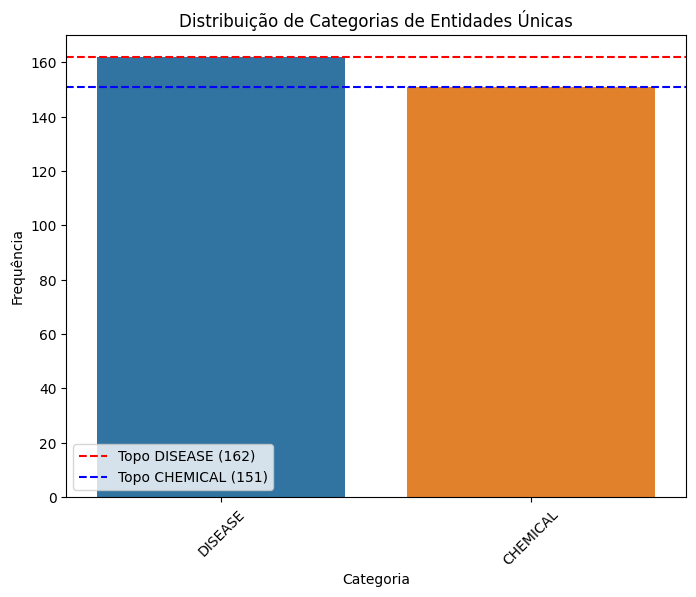

In [5]:
# Contagem de categorias para entidades únicas
#label_counts_unique = df_unique["Label"].value_counts()
#print(label_counts_unique)

unique_global = df_unique[["Entity", "Label"]].drop_duplicates()
label_counts_global = unique_global["Label"].value_counts()
print(label_counts_global)

plot_data = unique_global["Label"].value_counts().reset_index()
plot_data.columns = ["Label", "Frequency"]

plt.figure(figsize=(8, 6))
sns.barplot(data=plot_data, x="Label", y="Frequency", hue="Label", dodge=False)

plt.axhline(y=162, color="red", linestyle="--", label="Topo DISEASE (162)")

plt.axhline(y=151, color="blue", linestyle="--", label="Topo CHEMICAL (151)")

plt.title("Distribuição de Categorias de Entidades Únicas")
plt.xlabel("Categoria")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.legend()

plt.show()

## 6. Conclusão e Próximos Passos
Neste notebook, conseguimos realizar a extração de texto de prontuários médicos em formato PDF, aplicar técnicas de NER usando o spaCy e identificar entidades categorizadas como DISEASE e CHEMICAL. Os resultados mostram:

- Um total de 162 entidades únicas classificadas como DISEASE.
- Um total de 151 entidades únicas classificadas como CHEMICAL.

*Por que é relevante*:
1. Foco em Doenças e Substâncias Químicas: Saber que as categorias mais comuns são DISEASE (162) e CHEMICAL (151) pode ser um indicativo de que os prontuários estão ricos em informações relacionadas a diagnósticos e medicamentos, que são dados críticos em um contexto clínico.

2. Priorização de Análise: Essas categorias podem ser priorizadas em análises mais aprofundadas, como detecção de relações entre doenças e medicamentos ou padrões em tratamentos.

3. Validação do Modelo: Se o objetivo é validar a eficiência do modelo de NER aplicado, essa contagem ajuda a mensurar a robustez da extração e verificar se os resultados estão alinhados com o esperado para prontuários médicos.